In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from src.imagenet_x import get_factor_accuracies, error_ratio
from src.imagenet_x.utils import load_model_predictions, get_annotation_path
from src.imagenet_x import plots
from src.imagenet_x.evaluate import ImageNetX, get_vanilla_transform, ImageNetXImageFolder, load_annotations
import os
import pickle
from pathlib import Path

In [2]:
df1 = pd.read_csv('../metalabel_objectivity/val_imgs_df.csv')
samples = df1.sample(6)

samplescols = samples.columns[1:17]
k = samples.iloc[:, 1:17].values
samples_labels = []
l1 = []
for item in k:
    l1 = []
    for i, thing in enumerate(item):
        if thing == 1:
            l1.append(samplescols[i])
    samples_labels.append(l1)

samples['labels'] = samples_labels

root = "../data/ImageNetVal/"

l1 = {}
for path, subdirs, files in os.walk(root):
    for name in files:
        l1[name] = os.path.join(path, name)

samples['path'] = samples['file_name'].apply(lambda x: l1[x])

In [3]:
samples

,file_name,multiple_objects,background,color,brighter,darker,style,larger,smaller,object_blocking,...,pose,shape,subcategory,texture,justification,one_word,label,str_label,labels,path
30328,ILSVRC2012_val_00007867.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,right view image of piggy bank,right view,719,piggy bank,"[background, pattern, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0000786...
37319,ILSVRC2012_val_00013546.JPEG,0,1,1,0,0,0,0,0,0,...,1,0,0,0,Image of a kid playing with the horizontal bar.,yellow,602,horizontal bar,"[background, color, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0001354...
43224,ILSVRC2012_val_00030843.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,A bird lying on s nest.,nest angle,131,little blue heron,"[background, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0003084...
34096,ILSVRC2012_val_00034293.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,the squirrel monkey is a toy,toy,382,squirrel monkey,"[background, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0003429...
11114,ILSVRC2012_val_00012269.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,Sideview image of a butterfly.,angle,324,cabbage butterfly,"[background, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0001226...
14347,ILSVRC2012_val_00003327.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,A Brabancon griffon is running on snow,snow branch,262,Brabancon griffon,"[background, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0000332...


In [24]:
proto_df = pd.read_csv('../data/annotations/prototypical_paths.csv')
proto_df = proto_df.merge(df1, on='file_name', how='inner')

In [27]:
h_bar = proto_df[proto_df['label'] == samples.iloc[1]['label']]

KeyError: "None of [Index([  0,   0,   1,   1,   1,   2,   2,   3,   3,   3,\n       ...\n       996, 997, 997, 997, 998, 998, 998, 999, 999, 999],\n      dtype='int64', length=2758)] are in the [columns]"

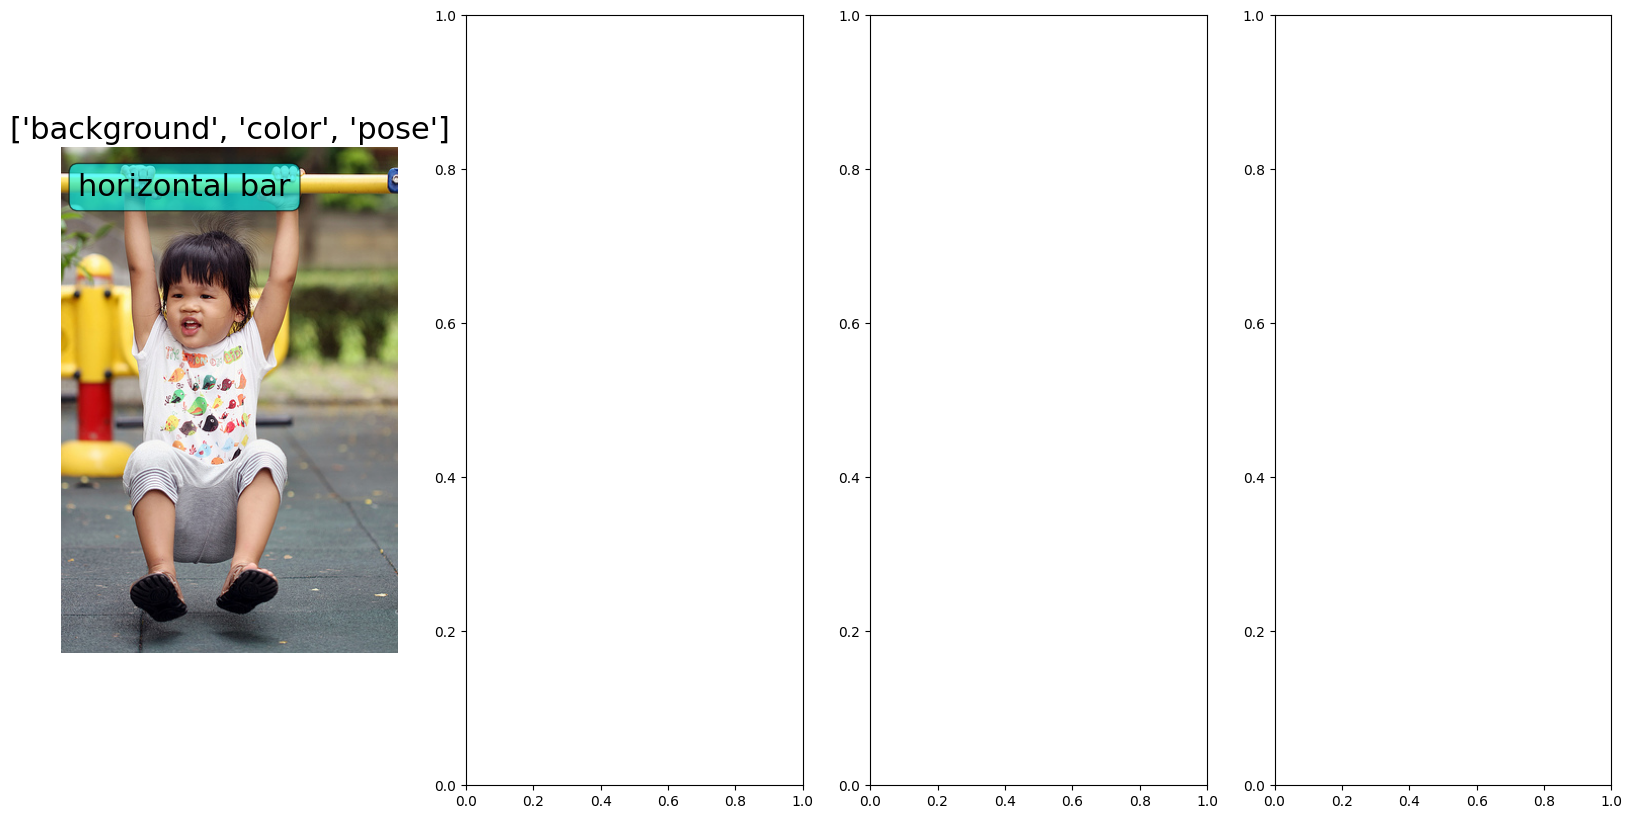

In [25]:
# plot 6 in a grid with matplotlib cropping them
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
img = plt.imread(samples.iloc[1]['path'])
ax[0].imshow(img)
ax[0].set_title(samples.iloc[1]['labels'], fontsize=22)
props = dict(boxstyle='round', facecolor='cyan', alpha=0.6)
ax[0].text(0.05, 0.95, samples.iloc[1]['str_label'], transform=ax[0].transAxes, fontsize=22,
    verticalalignment='top', bbox=props)
ax[0].axis('off')

for i, in range(1,3):
    img = plt.imread(proto_df[proto_df['label']] == samples.iloc[1]['label'])
    ax[i].imshow(img)
fig.tight_layout()

In [14]:
samples

,file_name,multiple_objects,background,color,brighter,darker,style,larger,smaller,object_blocking,...,pose,shape,subcategory,texture,justification,one_word,label,str_label,labels,path
30328,ILSVRC2012_val_00007867.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,right view image of piggy bank,right view,719,piggy bank,"[background, pattern, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0000786...
37319,ILSVRC2012_val_00013546.JPEG,0,1,1,0,0,0,0,0,0,...,1,0,0,0,Image of a kid playing with the horizontal bar.,yellow,602,horizontal bar,"[background, color, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0001354...
43224,ILSVRC2012_val_00030843.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,A bird lying on s nest.,nest angle,131,little blue heron,"[background, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0003084...
34096,ILSVRC2012_val_00034293.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,the squirrel monkey is a toy,toy,382,squirrel monkey,"[background, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0003429...
11114,ILSVRC2012_val_00012269.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,Sideview image of a butterfly.,angle,324,cabbage butterfly,"[background, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0001226...
14347,ILSVRC2012_val_00003327.JPEG,0,1,0,0,0,0,0,0,0,...,1,0,0,0,A Brabancon griffon is running on snow,snow branch,262,Brabancon griffon,"[background, pose]",../data/ImageNetVal/val\ILSVRC2012_val_0000332...
